# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!python --version

Python 3.9.20


In [2]:
%pip install keras-cv tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf

# Para verificar as especificações da GPU
gpu = tf.config.experimental.list_physical_devices('GPU')
print(gpu)

2024-11-06 10:42:08.678015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 10:42:08.680482: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 10:42:08.686929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730900528.697601   27898 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730900528.700630   27898 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 10:42:08.711717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

[]


2024-11-06 10:42:09.738122: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
%pip install --upgrade git+https://github.com/keras-team/keras-cv -q

Note: you may need to restart the kernel to use updated packages.


# Setup

In [7]:
%pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
from tqdm.auto import tqdm
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!

import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters


In [9]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [10]:
class_ids = [
    "ice-bag",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "./Ice-bag/train"
path_annot = "./Ice-bag/train"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [11]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

100%|██████████| 111/111 [00:00<00:00, 722.36it/s]


In [12]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [13]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [14]:
# bounding_boxes = {
#     # num_boxes may be a Ragged dimension
#     'boxes': Tensor(shape=[batch, num_boxes, 4]),
#     'classes': Tensor(shape=[batch, num_boxes])
# }

In [15]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

# Data Augmentation

In [16]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

# Creating Training Dataset


In [17]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# Creating Validation Dataset


In [18]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualization


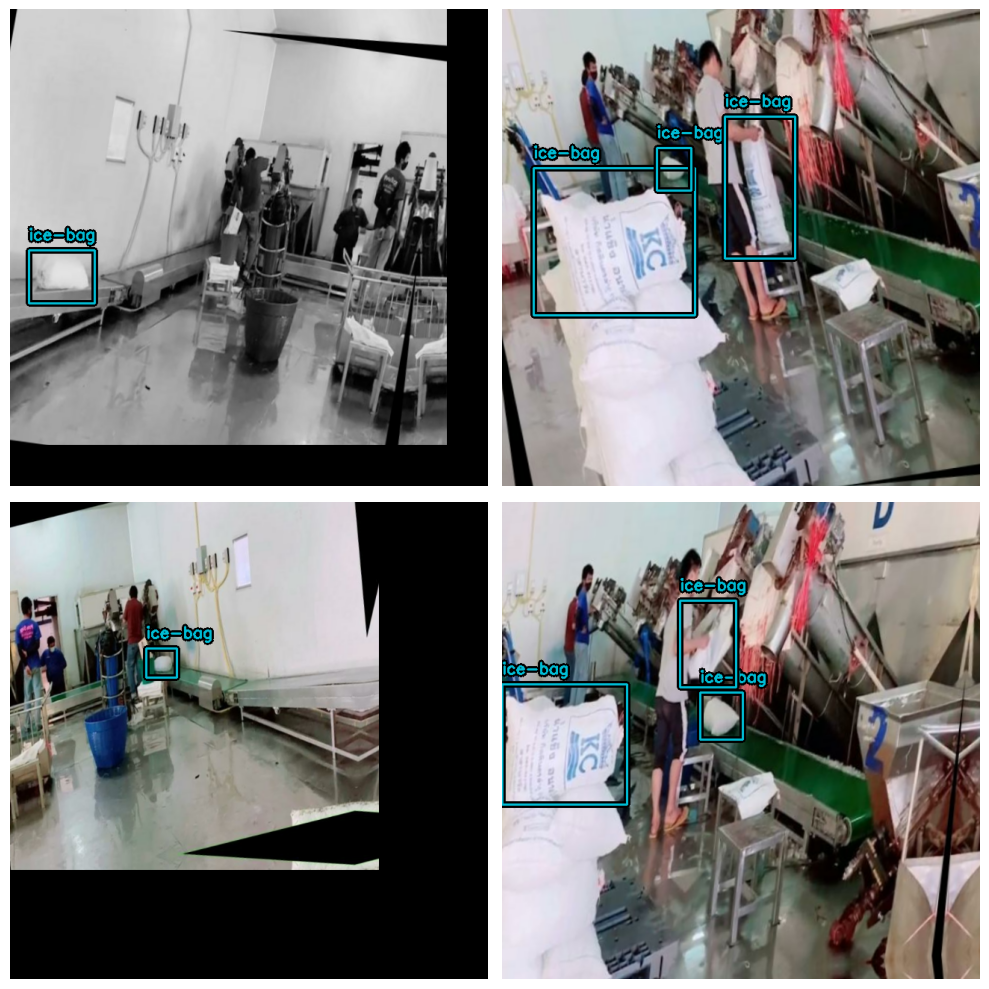

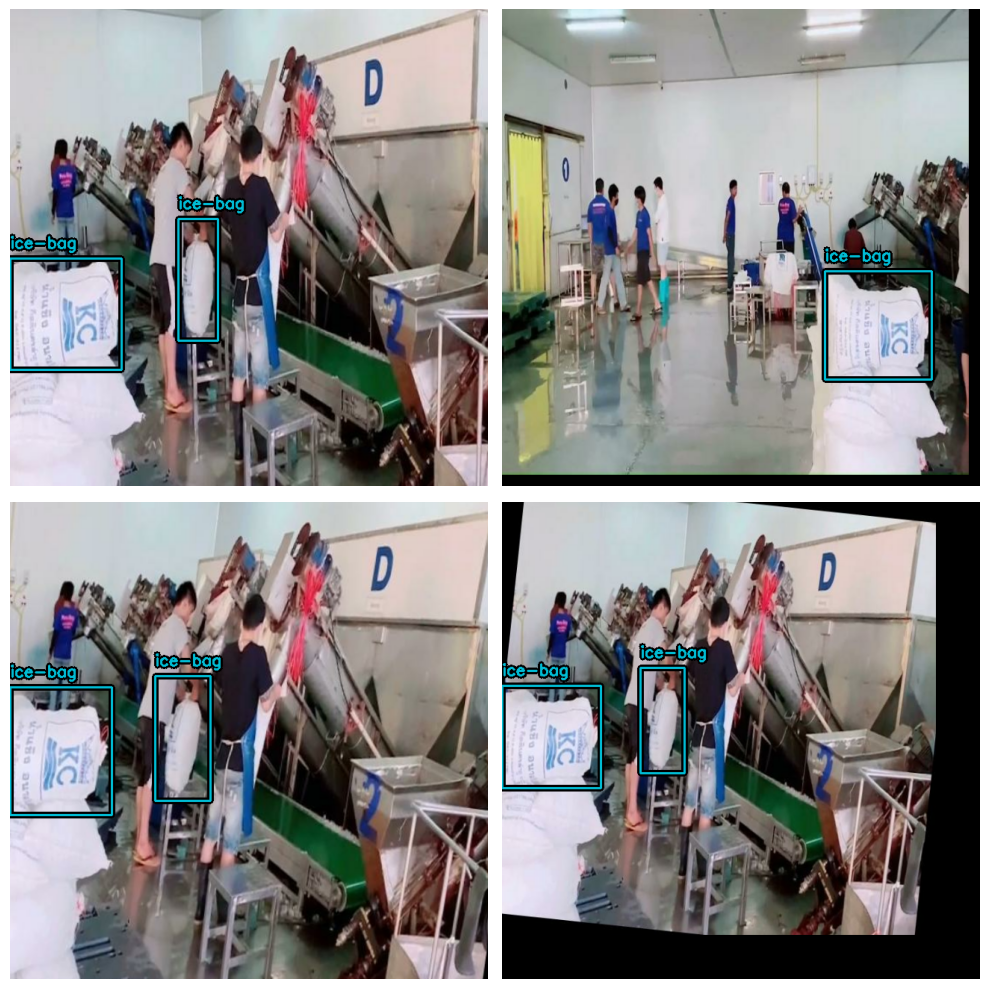

In [19]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [20]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Creating Model


In [21]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

100%|██████████| 646/646 [00:00<00:00, 1.56MB/s]


100%|██████████| 19.7M/19.7M [00:01<00:00, 10.7MB/s]


In [22]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [23]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [24]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

# Train the Model


In [25]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/3


/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - box_loss: 3.1982 - class_loss: 467.7238 - loss: 470.9220

2024-11-06 10:43:36.190856: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-06 10:43:36.198354: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,2,4] vs. shape[1] = [4,4,4]
2024-11-06 10:43:36.199780: W tensorflow/core/framework/op_kernel.cc:1829] UNKNOWN: InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_5_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,2,4] vs. shape[1] = [4,4,4] [Op:ConcatV2] name: concat
Traceback (most recent call last):

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3

UnknownError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_5_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,2,4] vs. shape[1] = [4,4,4] [Op:ConcatV2] name: concat
Traceback (most recent call last):

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 205, in result_on_host_cpu
    return tf.constant(obj_result(force), obj.dtype)

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 256, in result
    self._cached_result = self._compute_result()

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 264, in _compute_result
    _box_concat(self.ground_truths),

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 44, in _box_concat
    result[key] = tf.concat([b[key] for b in boxes], axis=0)

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/home/gutembergsa/miniconda3/envs/CustomModelTest/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 6002, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_5_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [4,2,4] vs. shape[1] = [4,4,4] [Op:ConcatV2] name: concat

 [Op:EagerPyFunc] name: 

# Visualize Predictions


In [26]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


NotImplementedError: `bounding_box.to_ragged` was called using a backend which does not support ragged tensors. Current backend: tensorflow.